*Problem Statement:*

    Implement anomaly detection for given credit card dataset using Autoencoder and build the model by using the following steps:
    a.	Import required libraries
    b.	Upload / access the dataset
    c.	Encoder converts it into latent representation
    d.	Decoder networks convert it back to the original input
    e.	Compile the models with Optimizer, Loss, and Evaluation Metrics


##Loading libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense

##Loading dataset in Python and taking a first look

In [6]:
dat=pd.read_csv('creditcard.csv')
dat.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset is highly unbalanced with very few fraudulent credit cards

In [7]:
dat['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot: xlabel='Class', ylabel='count'>

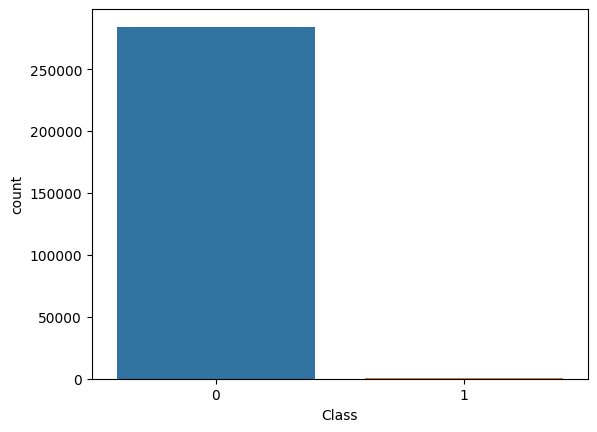

In [8]:
sns.countplot(x='Class',data=dat)

In [9]:
dat = dat.drop(['Time'], 1)
dat['Amount'] = StandardScaler().fit_transform(dat['Amount'].values.reshape(-1, 1))

/tmp/ipykernel_223408/3997603445.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dat = dat.drop(['Time'], 1)


Splitting into train and test datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dat.drop('Class',1) , dat['Class'], test_size=0.5, random_state=0)

/tmp/ipykernel_223408/3396225669.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(dat.drop('Class',1) , dat['Class'], test_size=0.5, random_state=0)


In [11]:
y_test.value_counts()

0    142161
1       243
Name: Class, dtype: int64

In [12]:
y_train.value_counts()

0    142154
1       249
Name: Class, dtype: int64

##First method: using autoencoder's regression error

For our first example we will train our autoencoder only on non fraudulent cases

In [13]:
X_train_normal = X_train[y_train==0]
X_train_fraud = X_train[y_train==1]

Building an autoencoder with
- an input layer with 29 neurons,
- a hidden layer with 12 neurons,
- an output layer with 29 neurons

In [14]:
input_layer = Input(shape=(29, ))
encoded = Dense(12,activation='tanh')(input_layer)
decoded = Dense(29,activation='sigmoid')(encoded)
autoencoder = Model(input_layer,decoded)

2022-11-13 23:28:59.267364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-13 23:28:59.267408: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-13 23:28:59.267442: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (utkarsh-ubuntu): /proc/driver/nvidia/version does not exist
2022-11-13 23:28:59.267803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [16]:
autoencoder.fit(X_train_normal, X_train_normal, epochs = 10, batch_size=128,validation_data=(X_train_normal,X_train_normal))

Epoch 1/10


2022-11-13 23:28:59.634726: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32979728 exceeds 10% of free system memory.
2022-11-13 23:28:59.720564: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32979728 exceeds 10% of free system memory.


1092/1111 [============================>.] - ETA: 0s - loss: 0.9976

2022-11-13 23:29:03.073768: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32979728 exceeds 10% of free system memory.


1111/1111 [==============================] - 5s 4ms/step - loss: 0.9957 - val_loss: 0.8832
Epoch 2/10
1111/1111 [==============================] - 4s 3ms/step - loss: 0.8588 - val_loss: 0.8416
Epoch 3/10
1111/1111 [==============================] - 2s 2ms/step - loss: 0.8316 - val_loss: 0.8230
Epoch 4/10
1111/1111 [==============================] - 2s 2ms/step - loss: 0.8170 - val_loss: 0.8115
Epoch 5/10
1111/1111 [==============================] - 2s 2ms/step - loss: 0.8073 - val_loss: 0.8032
Epoch 6/10
1111/1111 [==============================] - 4s 4ms/step - loss: 0.8002 - val_loss: 0.7972
Epoch 7/10
1111/1111 [==============================] - 4s 4ms/step - loss: 0.7949 - val_loss: 0.7927
Epoch 8/10
1111/1111 [==============================] - 4s 4ms/step - loss: 0.7910 - val_loss: 0.7893
Epoch 9/10
1111/1111 [==============================] - 3s 3ms/step - loss: 0.7881 - val_loss: 0.7867
Epoch 10/10
1111/1111 [==============================] - 2s 2ms/step - loss: 0.7858 - val_los

In [17]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train})
error_df.groupby('true_class').describe()

 145/4451 [..............................] - ETA: 3s

2022-11-13 23:29:32.186534: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33037496 exceeds 10% of free system memory.


4451/4451 [==============================] - 3s 746us/step


reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                      142154.0   0.784748   3.458053  0.036739  0.237561   
1                         249.0  30.390123  43.286610  0.152710  4.444087   

                                              
                  50%        75%         max  
true_class                                    
0            0.406304   0.663184  318.623476  
1           11.156569  27.567337  282.032375

As we can see above the error for non fraudulent case is lower than the error for fraudulent cases. We use a threshold of mean plus 3 sds to classify the test set.

In [18]:
test_predictions=autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
y_pred=[(lambda er: 1 if er>=11.078922  else 0)(er) for er in mse]

4451/4451 [==============================] - 7s 2ms/step


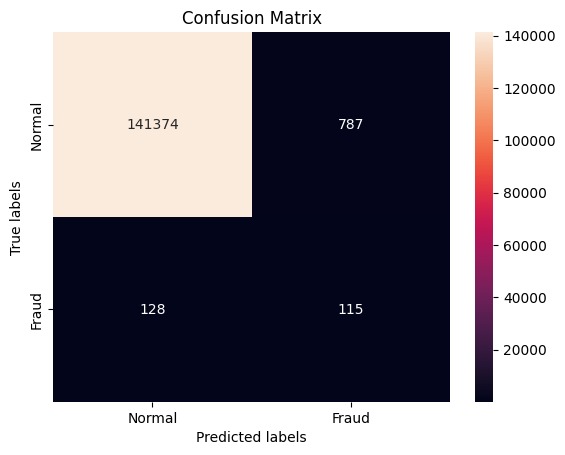

In [19]:
conf_matrix = metrics.confusion_matrix(y_test,y_pred)

ax=plt.subplot()
sns.heatmap(conf_matrix,annot=True,ax=ax,fmt='g')#annot=True to annotate cells, fmt='g' numbers not scientific form
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Fraud']); ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
ax.set(yticks=[0, 2], 
       xticks=[0.5, 1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))